In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Triangular_Lattice
from walker import Graphene_Walker

%load_ext autoreload
%matplotlib inline

## Visualize Moire Potential

<a list of 90 text.Text objects>

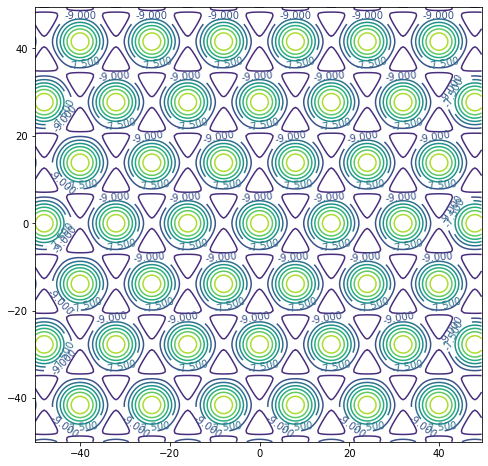

In [2]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

## Parameterize random walkers

In [3]:
%autoreload 2
from walker import Graphene_Walker
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1meV energy amplitude
walkers = Graphene_Walker(0.246, 15) # 2.46 Angstrom lattice, 10 Kelvin
tracks = walkers.get_tracks(moire, nsteps=300, njumps=100000, nparticles=100)

KeyboardInterrupt: 

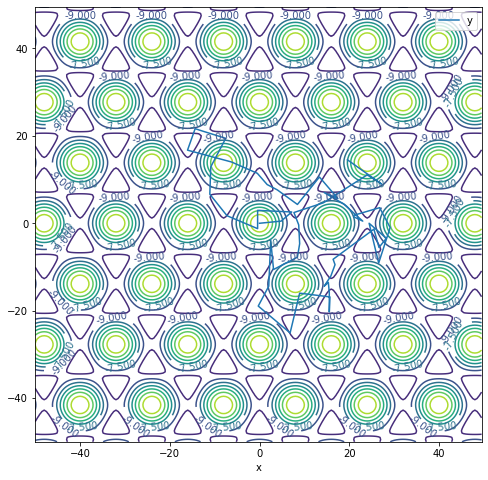

In [5]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
tracks[tracks['particle'] == 0].plot(x = 'x', y='y', ax=ax)

# Wait Time Tail

In [6]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product

temps = [4, 6, 8, 10, 12, 14, 16]
lattice_constants = [4, 8, 12, 16]
barrier = 19.8

kws = {
    'njumps' : 1000000, 
    'nparticles' : 10, 
    'init' : 1000,
}

def get_waits(m_lattice, temperature, total_particles=1000, **kws):
    moire = Triangular_Lattice(m_lattice, barrier) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    tracks = walkers.walk(**kws)
    waits = np.random.choice(walkers.get_waits(moire, tracks, **kws).flatten(), size=1000000)
    return waits
result = Parallel(n_jobs=-1, prefer='threads')(delayed(get_waits)(m_lattice, temperature, **kws) for m_lattice, temperature in tqdm(product(lattice_constants, temps)))
print('done')

28it [00:11,  2.38it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'PDF')

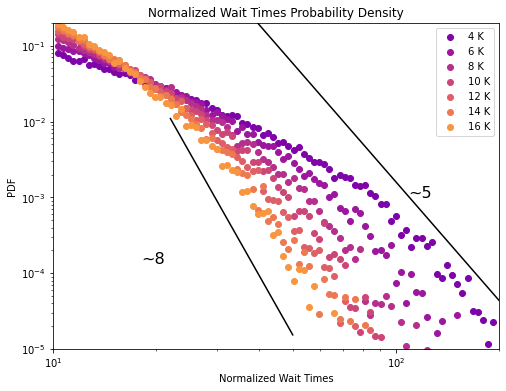

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
col = plt.cm.plasma(np.linspace(0.25, 0.75, len(temps)))
waits = np.array(result).reshape((len(lattice_constants), len(temps), 1000000))
for i, T in enumerate(temps):
    yy, xx = np.histogram(waits[3, i] / np.mean(waits[3, i]), np.logspace(1, np.log10(3e2), 100), density=True)
    xmax = np.max(xx)
    ax.scatter(xx[1:-1], yy[1:], color=col[i], label='{} K'.format(T))
ax.set_ylim(1e-5, 2e-1)
ax.set_xlim(10, 200)
ax.plot(xx[xx>(0.1*xmax)], 4e7*xx[xx>(0.1*xmax)]**(-5.2), color='k')
xx = np.linspace(22, 50, 100)
ax.plot(xx[xx>(0.01*xmax)], 6e8*xx[xx>(0.01*xmax)]**(-8), color='k')
ax.legend()
ax.annotate('~5', (200, 1e-4),
            xytext=(0.85, 0.5), textcoords='axes fraction',
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
ax.annotate('~8', (200, 1e-4),
            xytext=(0.25, 0.3), textcoords='axes fraction',
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.title('Normalized Wait Times Probability Density')
plt.xlabel('Normalized Wait Times')
plt.ylabel('PDF')

## Distribution of Displacement

In [7]:
def plot_hist_dots(ax, x,y, xmin="", xmax="", title="", text="", log=False):


    dx1 = np.concatenate([np.diff(x),np.diff(y)])
    yy, xx = np.histogram(dx1, 50, density=True)
    
    xmax = np.max(xx[xx>0])
    xmin = np.min(xx[xx>0])

    ymin = np.min(yy[yy>0])
    ymax = np.max(yy[yy>0])
    
    xx = xx[:-1] + (xx[1] - xx[0])/2
    
    ax.scatter(xx, yy, c='gray', marker='o', s=40)
#     ax.plot(xx[xx>(0.1*xmax)], 0.05*xx[xx>(0.1*xmax)]**(-3), ls='-',color='coral')
    ax.plot(xx[xx>(0.2*xmax)], 0.05*xx[xx>(0.2*xmax)]**(-3), ls='-',color='coral')
    ax.text(0.9, 0.6,r'$\delta x^{-3.0}$', fontsize=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)
    ax.set_xlabel(r'Displacement $\delta x(t_{fr})$',fontsize=16)

    ax.margins(0.1)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(1e-1,10)
    ax.set_title(title,fontsize=14)
    if log:
        ax.set_yscale('log')
        ax.set_xscale('log')
    return ax

CPU times: user 16.9 s, sys: 2.58 s, total: 19.5 s
Wall time: 18.8 s


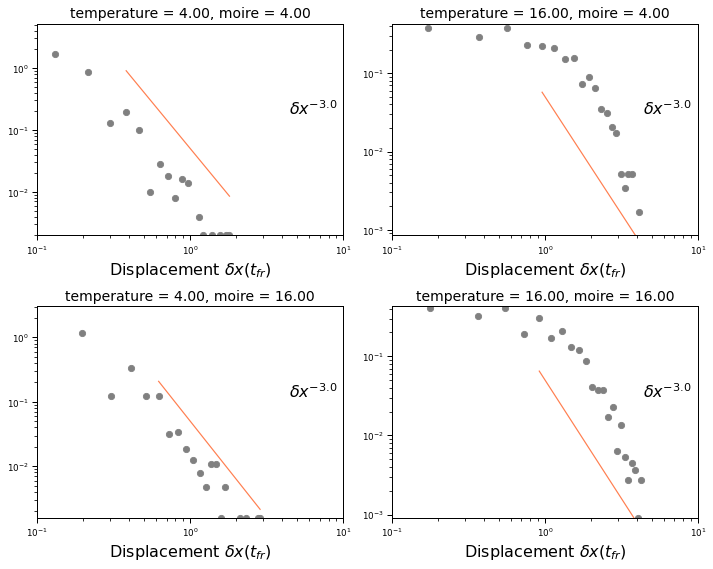

In [8]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
import seaborn as sns

temperature = [4,16]
periodicity = [4,16]
barrier = 19.8

kws = {
    'njumps' : 1000000, 
    'nparticles' : 10, 
    'init' : 1000,
}
with sns.plotting_context("paper"):
    fig, axes = plt.subplots(2, 2, figsize=(10,8))  
    for i,period in enumerate(periodicity):
        for j,temp in enumerate(temperature):

            ax = axes.flatten()[2*i+j]
           ## generate tracks at that temperature
            moire = Triangular_Lattice(period, 2) # 16nm lattice constant, 1meV energy amplitude
            walkers = Graphene_Walker(0.246, temp) # 2.46 Angstrom lattice, 10 Kelvin
            tracks = walkers.get_tracks(moire, nsteps=300, njumps=1000000, nparticles=10, endT=1e5)
#             waits = np.random.choice(walkers.get_waits(moire, tracks, **kws).flatten(), size=1000000)
            ## gather x and y values
            x = []
            y = []
            for particle in list(set(tracks['particle'])):
                x.append(np.array(tracks[tracks['particle'] == particle]['x']))
                y.append(np.array(tracks[tracks['particle'] == particle]['y']))
            x = np.array(x)
            y = np.array(y)

            title='temperature = {:.2f}, moire = {:.2f}'.format(temp, period)
            ax = plot_hist_dots(ax, x,y,title=title,log=True)
            fig.tight_layout()
fig.savefig('./displacement_dist.png', dpi=300, bbox_inches='tight')

## Temperature Plots (figure 3)

In [4]:
%autoreload 2
from utils import *
from walker import Graphene_Walker

In [89]:
temperatures = [21, 23, 25, 27]
periodicity = [4, 8, 12, 16]
barrier = 19.8
nsteps = 300

period_temp_activations = []
period_temp_predictions = []
period_temp_values = []
period_num_fbm = []
period_num_brownian = []
period_num_ctrw = []
avg_period_temp_values = []
std_period_temp_values = []
 

for period in periodicity:
    all_temp_activations = []
    all_temp_predictions = []
    all_temp_values = []
    avg_all_temp_values = []
    std_all_temp_values = []
    num_fbm = []
    num_brownian = []
    num_ctrw = []
    for temp in temperatures:
        print(period, temp)
        ## generate tracks at that temperature
        moire = Triangular_Lattice(period, barrier) # 16nm lattice constant, 1meV energy amplitude
        walkers = Graphene_Walker(0.246, temp) # 2.46 Angstrom lattice, 10 Kelvin
        tracks = walkers.get_tracks(moire, nsteps=nsteps, njumps=100000, nparticles=400) #endT=1e5

        ## gather x and y values
        x = []
        y = []
        for particle in list(set(tracks['particle'])):
            x.append(np.array(tracks[tracks['particle'] == particle]['x']))
            y.append(np.array(tracks[tracks['particle'] == particle]['y']))
        x = np.array(x)
        y = np.array(y)

        ## calculate dx and y
        temp_x = x-np.mean(x)
        temp_dx = np.diff(temp_x)
        temp_dx = temp_dx/np.std(temp_dx)

#         print(temp_dx)
        ## trim x and y to shape
        temp_dx = temp_dx[:,::int(temp_dx.shape[1] / nsteps)][:,:-1]

        temp_values, temp_predictions = classification_on_real(temp_dx, steps=nsteps) #values is the probability value, prediction is the predicted class (0,1,2)
        all_temp_activations.append(get_activations(temp_dx, steps=nsteps))

        num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
        num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
        num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))

        
        avg_temp_values = np.mean(temp_values, axis=0) #average probability over all particles from that temp and period
        std_temp_values = np.std(temp_values, axis=0) #std of probability over all particles from that temp and period


        all_temp_predictions.append(temp_predictions)
        all_temp_values.append(temp_values)
        avg_all_temp_values.append(avg_temp_values)
        std_all_temp_values.append(std_temp_values)

    period_temp_activations.append(all_temp_activations)
    period_temp_predictions.append(all_temp_predictions)
    period_temp_values.append(all_temp_values)
    period_num_fbm.append(num_fbm)
    period_num_brownian.append(num_brownian)
    period_num_ctrw.append(num_ctrw)
    avg_period_temp_values.append(avg_all_temp_values)
    std_period_temp_values.append(std_all_temp_values)

all_temp_activations = np.array(all_temp_activations)

4 21
4 23
4 25
4 27
8 21
8 23
8 25
8 27
12 21
12 23
12 25
12 27
16 21
16 23
16 25
16 27


In [94]:
std_period_temp_values

[[array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32)],
 [array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32)],
 [array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32)],
 [array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32),
  array([nan, nan, nan], dtype=float32)]]

In [90]:
mtx = np.asarray(avg_period_temp_values)
err = np.asarray(std_period_temp_values)

<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\eric_\Anaconda3\lib\site-packages\numpy\ma\core.py:717: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


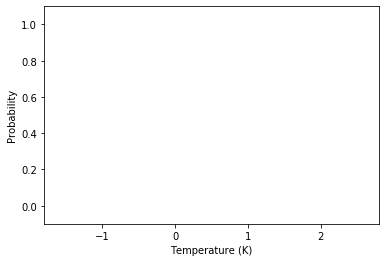

In [91]:
for ind,per in enumerate(periodicity[0:4]):
    x = temperatures
    plt.errorbar(x,mtx[ind,:,2],err[ind,:,2],c='lightgray',zorder=0)
    plt.errorbar(x,mtx[ind,:,1],err[ind,:,2],c='lightgray',zorder=0)
    plt.scatter(x,mtx[ind,:,2],c=x,cmap=plt.cm.Blues,label='ctrw probability')
    plt.scatter(x,mtx[ind,:,1],c=x,cmap=plt.cm.Reds,label='Brownian probability')
plt.xlabel("Temperature (K)")
plt.ylabel("Probability")
plt.ylim((-0.1,1.1))
# plt.legend()
plt.savefig('./probabilityvaluesMoNet-400part_19-8barrier_300steps_endTscaled.png', dpi=300, bbox_inches='tight')

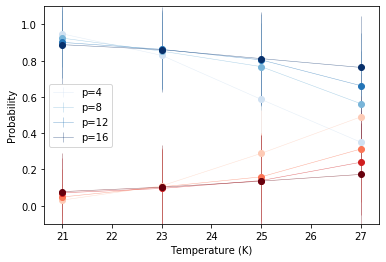

In [10]:
import matplotlib.pylab as pl
colors_ctrw = pl.cm.Blues(np.linspace(0.2,1,4))
colors_brown = pl.cm.Reds(np.linspace(0.2,1,4))
for ind,per in enumerate(periodicity):
    x = temperatures
    label_p = 'p='+str(per)
    plt.errorbar(x,mtx[ind,:,2],err[ind,:,2],color=colors_ctrw[ind],zorder=0,linewidth=0.5,alpha=0.6,label=label_p)
    plt.errorbar(x,mtx[ind,:,1],err[ind,:,2],color=colors_brown[ind],zorder=0,linewidth=0.5,alpha=0.6)
    plt.scatter(x,mtx[ind,:,2],color=colors_ctrw[ind])
    plt.scatter(x,mtx[ind,:,1],color=colors_brown[ind])
plt.xlabel("Temperature (K)")
plt.ylabel("Probability")
plt.ylim((-0.1,1.1))
plt.legend()
plt.savefig('./probabilityvaluesMoNet-400part_19-8barrier_300steps_endTscaled.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Temperature vs Proportion of Class')

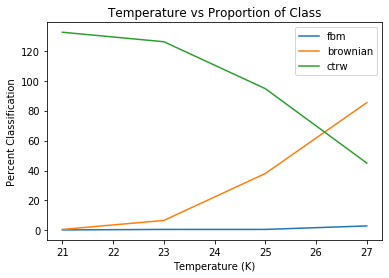

In [11]:
x = temperatures
plt.plot(x, np.array(period_num_fbm[0]) / 3, c="tab:blue",label="fbm")
plt.plot(x, np.array(period_num_brownian[0]) / 3, c="tab:orange", label="brownian")
plt.plot(x, np.array(period_num_ctrw[0]) / 3, c="tab:green",label="ctrw")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Percent Classification")
plt.title("Temperature vs Proportion of Class")

## UMap

In [78]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def manifold(dx, predictions, s=30, ax=None, markers = ["o",">","s"], colors="tab:blue", fbm_coeffs=None, ctrw_alphas=None, embedding_name="umap"):
    if embedding_name == "tsne":
        embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)
    elif embedding_name == 'umap':
        num_temps = dx.shape[0]
        dx_scaled = np.concatenate([StandardScaler().fit_transform(x) for x in dx], axis = 0)
        embedded_dx = UMAP(random_state=12345).fit_transform(dx_scaled)
        
        interval_size = len(embedded_dx) // num_temps
        fbm_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 0]) for i in range(num_temps)]
#         [print(x.shape) for x in fbm_points]
        ctrw_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 1]) for i in range(num_temps)]
#         [print(x.shape) for x in ctrw_points]
        brownian_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 2]) for i in range(num_temps)]
#         [print(x.shape) for x in brownian_points]

        fbm = None
        ctrw = None
        brownian = None
        plt_list = []
        plt_names = []
        if ax is None:
            ax = plt.axes()
            ax.figure.set_size_inches(12,8)
        
        for i in range(num_temps):
            if len(fbm_points[i]) != 0:
                fbm = ax.scatter(fbm_points[i][:,0], fbm_points[i][:,1], s=s, c=colors[i],marker=markers[0], edgecolors='black')
            
            
            ctrw = ax.scatter(ctrw_points[i][:,0], ctrw_points[i][:,1], s=s, c=colors[i], marker=markers[1], edgecolors='black')
        
            
            brownian = ax.scatter(brownian_points[i][:,0], brownian_points[i][:,1], s=s, c=colors[i], marker=markers[2],edgecolors='black')
           

        plt_list.append(fbm)
        plt_names.append("fbm")
        
        plt_list.append(ctrw)
        plt_names.append("ctrw")
        
        plt_list.append(brownian)
        plt_names.append("brownian")
        
        plt.legend(plt_list, plt_names)
        return ctrw, ax
    else:
        raise NotImplementedError

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

(<matplotlib.collections.PathCollection at 0x171234300c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17121123488>)

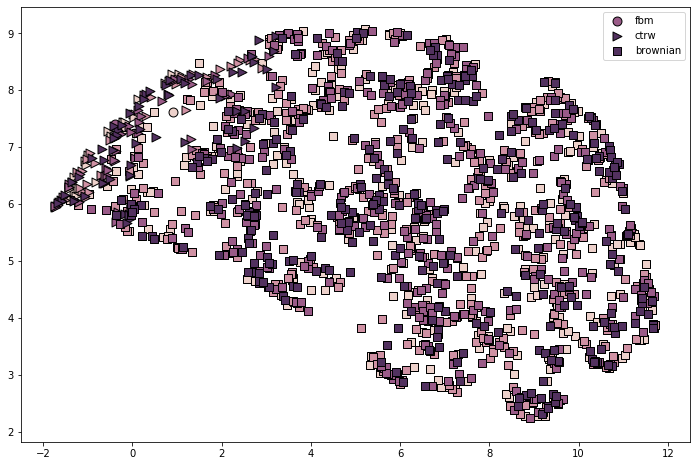

In [80]:
import seaborn as sns
marker_size = 80
colors = sns.cubehelix_palette(7)
manifold(np.array(period_temp_activations[3])[0:4].squeeze(), np.concatenate(period_temp_predictions[3]), s = marker_size, colors=sns.cubehelix_palette(8)[::2])

In [77]:
np.array(period_temp_activations[0])[0:4].squeeze().shape

(4, 400, 192)

In [58]:
sns.cubehelix_palette(8)[::2]

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8135380254700676, 0.5705055182357822, 0.639280859468155],
 [0.6046906802634469, 0.35739308184976665, 0.5337407853692406],
 [0.3210194743259347, 0.19303051265196464, 0.3707881677724792]]

In [43]:
np.concatenate(all_temp_predictions).shape

(1600, 2)

In [82]:
net_file = 'models/300_new_model.h5'
model = load_model(net_file)


In [88]:
[layer.name for layer in model.layers]

['input_1',
 'conv1d',
 'conv1d_3',
 'conv1d_6',
 'conv1d_9',
 'conv1d_12',
 'batch_normalization',
 'batch_normalization_3',
 'batch_normalization_6',
 'batch_normalization_9',
 'batch_normalization_12',
 'conv1d_1',
 'conv1d_4',
 'conv1d_7',
 'conv1d_10',
 'conv1d_13',
 'batch_normalization_1',
 'batch_normalization_4',
 'batch_normalization_7',
 'batch_normalization_10',
 'batch_normalization_13',
 'conv1d_2',
 'conv1d_5',
 'conv1d_8',
 'conv1d_11',
 'conv1d_14',
 'conv1d_18',
 'batch_normalization_2',
 'batch_normalization_5',
 'batch_normalization_8',
 'batch_normalization_11',
 'batch_normalization_14',
 'batch_normalization_18',
 'global_average_pooling1d',
 'global_average_pooling1d_1',
 'global_average_pooling1d_2',
 'global_average_pooling1d_3',
 'global_average_pooling1d_4',
 'global_average_pooling1d_6',
 'concatenate',
 'dense',
 'dense_1',
 'dense_2',
 'dense_3',
 'dense_4',
 'dense_5']